In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Library for boxplots
import seaborn as sns
#ahmed

In [3]:
key_stats = pd.read_csv('key_stats.csv')
attacking = pd.read_csv('attacking.csv')
defending = pd.read_csv('defending.csv')
attempts = pd.read_csv('attempts.csv')
disciplinary = pd.read_csv('disciplinary.csv')
distributon = pd.read_csv('distributon.csv')
goalkeeping = pd.read_csv('goalkeeping.csv')
goals = pd.read_csv('goals.csv')

In [4]:
# feature engineering

attempts['attempts_accuracy'] = 100 * attempts['on_target'] / attempts['total_attempts']
defending['tackles_accuracy'] = 100* defending['t_won'] / defending['tackles']
defending['balls_recoverd_per_match'] = defending['balls_recoverd'] / defending['match_played']
goals['goals_per_match'] = goals['goals'] / goals['match_played']
goalkeeping['gk_accuracy'] = 100 * goalkeeping['saved'] / (goalkeeping['saved']+goalkeeping['conceded'])
goalkeeping['cleansheets_rate'] = 100 * goalkeeping['cleansheets'] / goalkeeping['match_played']

In [5]:
# merged dataframe

dataframes = [key_stats, attacking, defending, attempts, disciplinary, distributon, goalkeeping, 
              goals]

df = dataframes[0]

for data in dataframes[1:]:
    df = pd.merge(df, data, on='player_name', how='outer', suffixes=('', '_duplicate'))

df = df.loc[:, ~df.columns.str.endswith('_duplicate')]
df = df.loc[:, ~df.columns.str.contains('serial')]
df.head()

,player_name,club,position,minutes_played,match_played,goals,assists,distance_covered,corner_taken,offsides,...,gk_accuracy,cleansheets_rate,right_foot,left_foot,headers,others,inside_area,outside_areas,penalties,goals_per_match
0,Aaronson,Salzburg,Midfielder,715.0,8.0,0.0,2.0,103.5,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Abubakari,Malmö,Forward,116.0,4.0,0.0,0.0,15.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Acuña,Sevilla,Defender,379.0,5.0,0.0,0.0,43.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adams,Leipzig,Midfielder,292.0,5.0,0.0,0.0,38.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adamu,Salzburg,Forward,231.0,8.0,1.0,0.0,32.6,NaN,NaN,...,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.125


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_name               1003 non-null   object 
 1   club                      1002 non-null   object 
 2   position                  1002 non-null   object 
 3   minutes_played            1002 non-null   float64
 4   match_played              1002 non-null   float64
 5   goals                     1002 non-null   float64
 6   assists                   1002 non-null   float64
 7   distance_covered          1002 non-null   object 
 8   corner_taken              328 non-null    float64
 9   offsides                  328 non-null    float64
 10  dribbles                  328 non-null    float64
 11  balls_recoverd            888 non-null    float64
 12  tackles                   888 non-null    float64
 13  t_won                     888 non-null    float64
 14  t_lost  

In [7]:
df.describe()

,minutes_played,match_played,goals,assists,corner_taken,offsides,dribbles,balls_recoverd,tackles,t_won,...,gk_accuracy,cleansheets_rate,right_foot,left_foot,headers,others,inside_area,outside_areas,penalties,goals_per_match
count,1002.000000,1002.000000,1002.000000,1002.000000,328.000000,328.000000,328.000000,888.000000,888.000000,888.000000,...,134.000000,134.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,342.150699,5.194611,0.428144,0.363273,2.158537,0.762195,6.341463,18.012387,5.304054,2.194820,...,83.598326,63.940115,0.924765,0.514107,0.188088,0.012539,1.297806,0.344828,0.112853,0.246109
std,239.140607,2.644628,1.166176,0.821641,5.028286,1.789753,8.747521,15.332058,4.817282,2.444259,...,19.613152,43.092786,1.127409,0.944508,0.491163,0.111449,1.641357,0.532199,0.426840,0.196787
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,42.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923
25%,139.750000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000,1.000000,0.000000,...,66.666667,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000
50%,326.000000,5.000000,0.000000,0.000000,0.000000,0.000000,3.000000,13.000000,4.000000,1.000000,...,100.000000,100.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667
75%,499.750000,7.000000,0.000000,0.000000,1.000000,1.000000,7.000000,24.000000,9.000000,3.000000,...,100.000000,100.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.333333
max,1230.000000,13.000000,15.000000,7.000000,36.000000,10.000000,83.000000,76.000000,35.000000,18.000000,...,100.000000,100.000000,11.000000,8.000000,3.000000,1.000000,13.000000,3.000000,3.000000,1.375000


c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\eloua\AppData\Local\Programs\Python\Python310

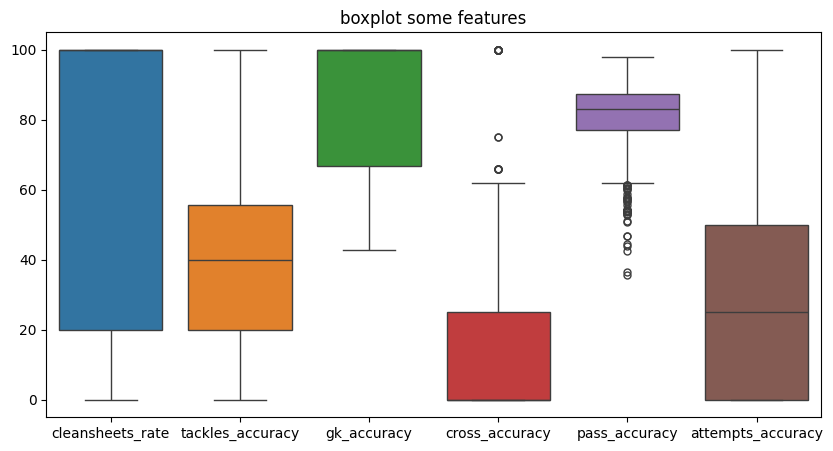

In [8]:
plt.figure(figsize=((10,5)))
plt.title('boxplot some features')
soccer_box=sns.boxplot(data=df[['cleansheets_rate', 'tackles_accuracy','gk_accuracy', 'cross_accuracy', 'pass_accuracy', 'attempts_accuracy']],fliersize=5)   # fliersize is the size used to indicate the outliers
plt.show()

c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\eloua\AppData\Local\Programs\Python\Python310

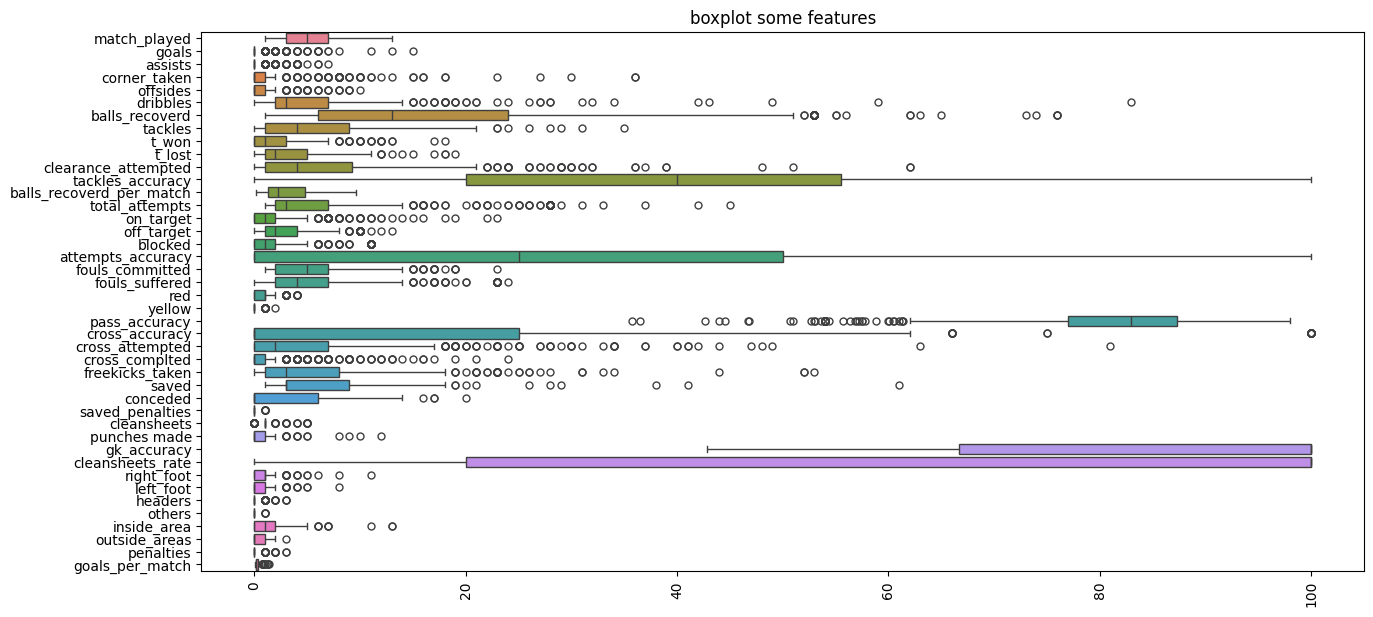

In [9]:
plt.figure(figsize=((15,7)))
plt.title('boxplot some features')
data = df.drop(columns=['minutes_played', 'pass_attempted', 'pass_completed'])
food_box=sns.boxplot(data=data,fliersize=5, orient='h')
plt.xticks(rotation=90)
plt.show()

c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\eloua\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\eloua\AppData\Local\Programs\Python\Python310

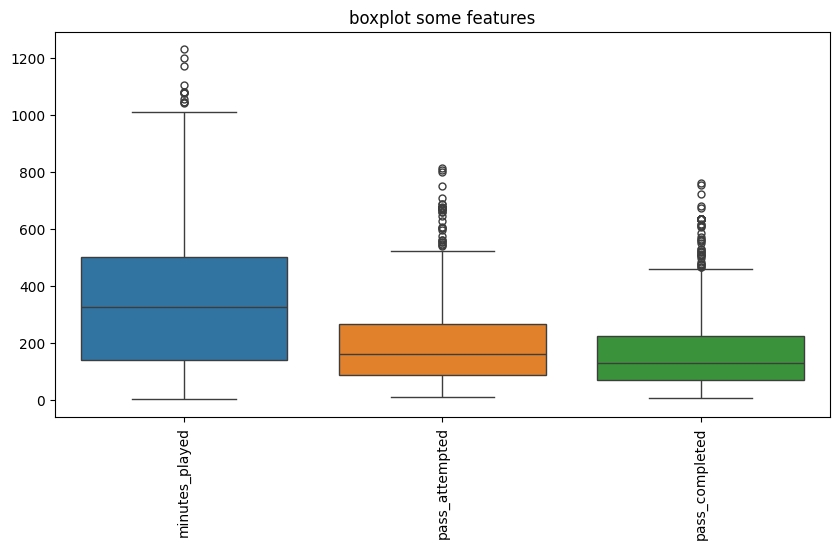

In [10]:
plt.figure(figsize=((10,5)))
plt.title('boxplot some features')
data = df[['minutes_played', 'pass_attempted', 'pass_completed']]
food_box=sns.boxplot(data=data,fliersize=5)
plt.xticks(rotation=90)
plt.show()

# Factorial analysis

In [11]:
def plot_corr(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap)

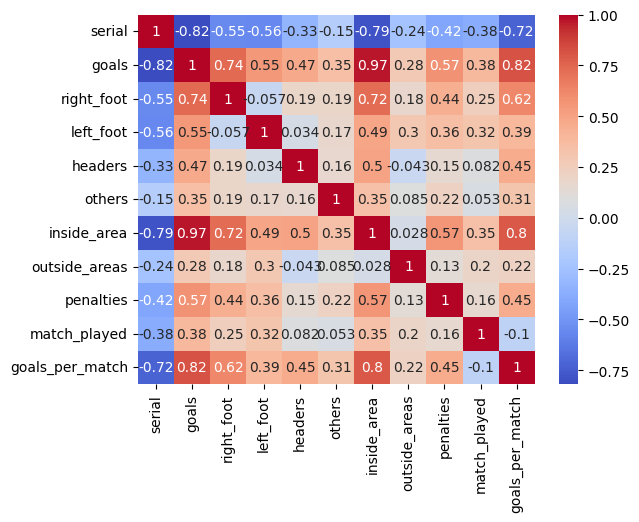

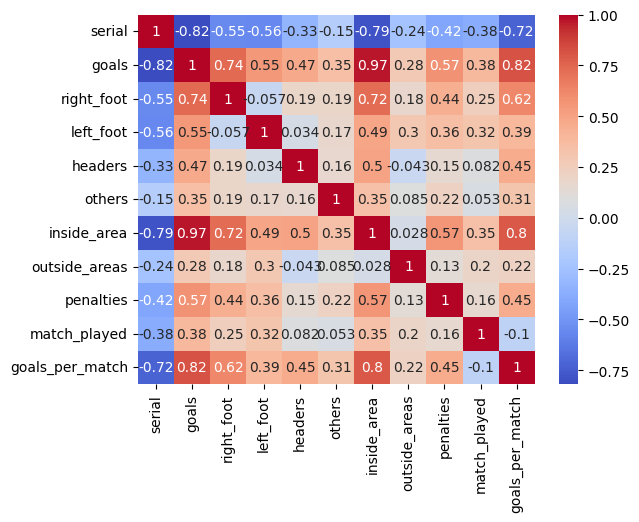

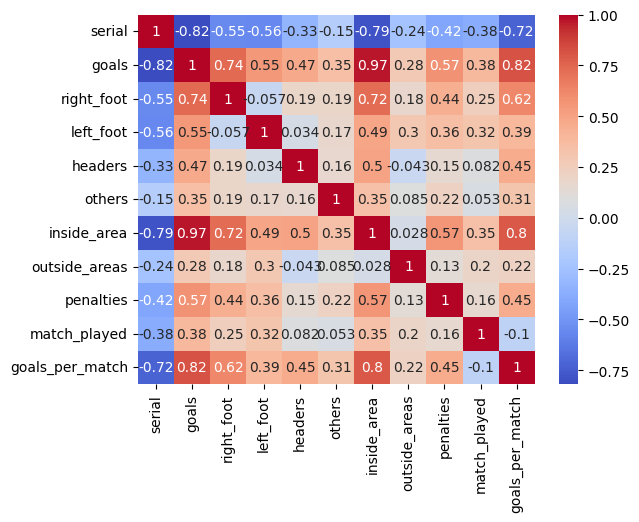

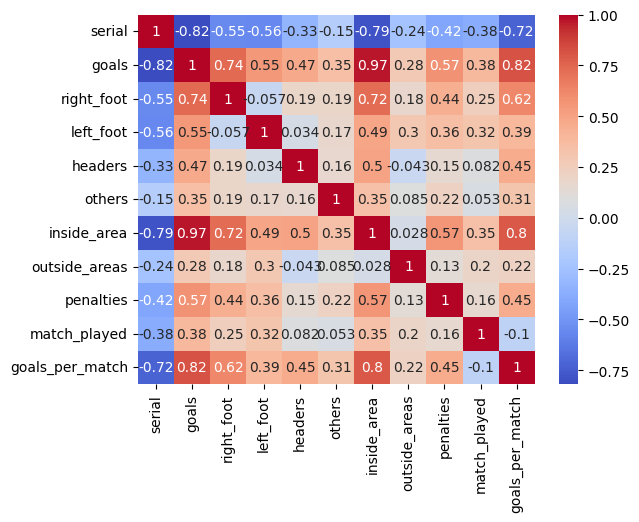

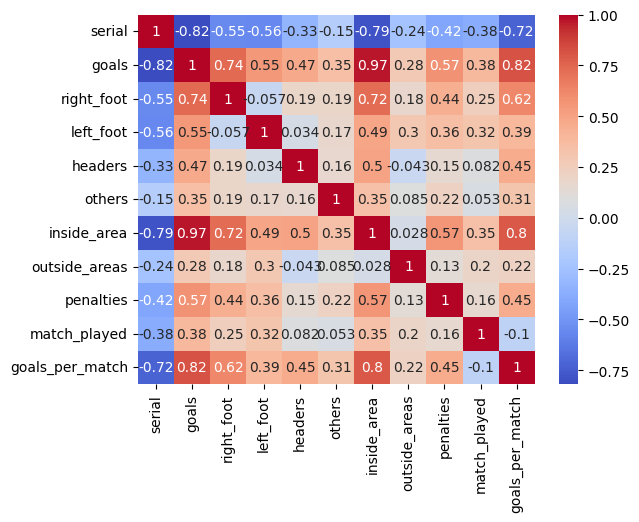

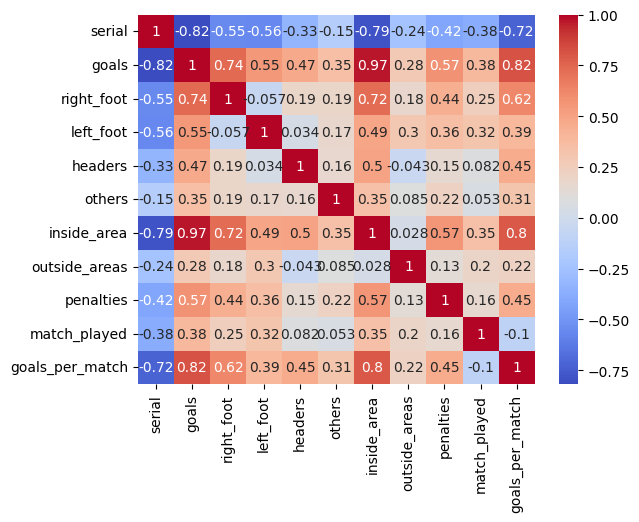

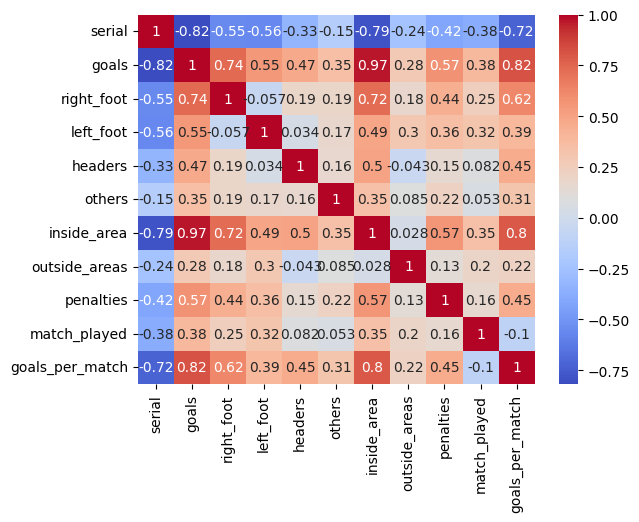

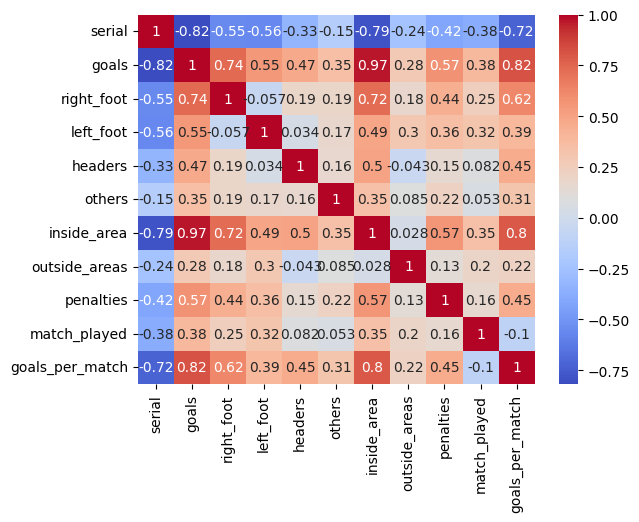

In [32]:
for dataframe in dataframes:
    corr = data.select_dtypes(exclude='object').corr()
    if corr.shape[0] > 1 and not corr.isnull().all().all():
        plt.figure()
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.show()
    else:
        print("La matrice de corrélation est vide ou n'a qu'une seule colonne.")

<Axes: >

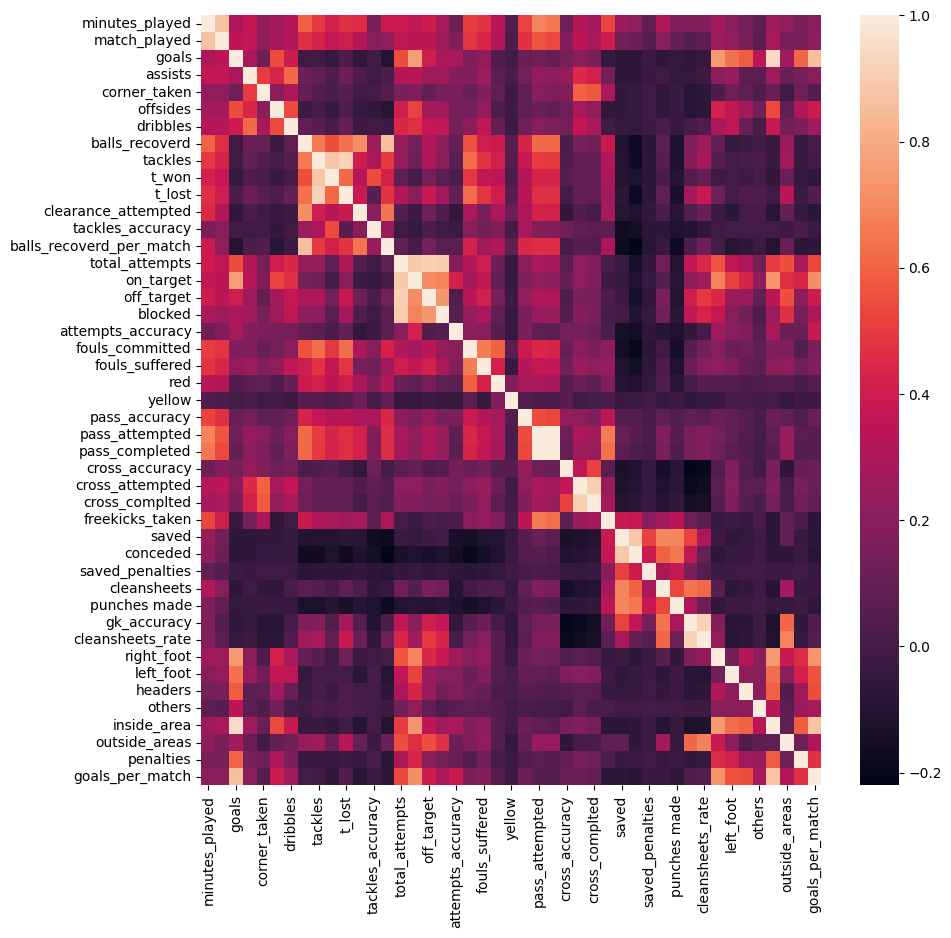

In [30]:
corr = df.select_dtypes(exclude='object').fillna(value=0).corr()
plt.figure(figsize=((10,10)))
sns.heatmap(corr)

# PCA

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [51]:
X = df.select_dtypes(exclude='object').fillna(value=0).values
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [52]:
pca = PCA().fit(X_scaled)

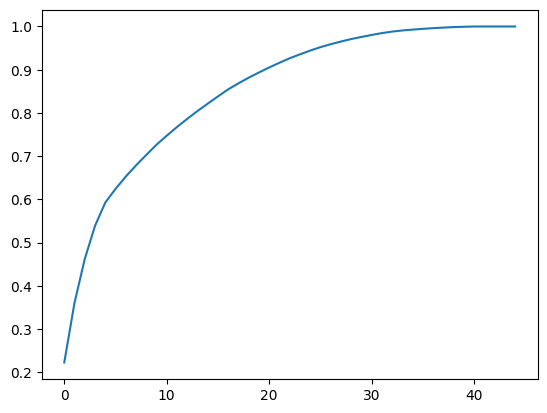

In [53]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))